In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"
from IPython.display import Image
plt.rc('font', family="AppleGothic")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.stats.multicomp import MultiComparison

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import stats
import scipy 
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
grid_250 = pd.read_csv('/Users/gimdong-wan/Desktop/DataCampus/data/real_data/250grid_data.csv')

In [3]:
grid_250 = grid_250.fillna(0)

In [4]:
len(grid_250)

3498

In [5]:
grid_250['성폭력취약인구'] = grid_250['고등여성인구']+grid_250['20대여성인구']
grid_250['건축물(30_)'] = grid_250['건축물(30_34)']+grid_250['건축물(35)']
grid_250['GRADE_폭력'] = grid_250['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_절도'] = grid_250['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)
grid_250['GRADE_성폭력'] = grid_250['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)
grid_250 = grid_250.drop(columns = ['20대여성인구','고등여성인구','INDEX'])

### 행정동별로 평균 범죄주의구간 등급 확인

In [6]:
feat_N = grid_250[(grid_250['총인구']==0)&(grid_250['건축물(30_34)']==0)&(grid_250['건축물(35)']==0)&(grid_250['가로등']==0)&(grid_250['공영주차장']==0)&(grid_250['공중화장실']==0)&(grid_250['숙박업소']==0)
        &(grid_250['대규모점포']==0)&(grid_250['대부업현황']==0)&(grid_250['상가']==0)&(grid_250['어린이보호']==0)&(grid_250['원룸_오피스텔']==0)&(grid_250['cctv']==0)&(grid_250['신호등']==0)&(grid_250['횡단보도']==0)
        &(grid_250['버스정류장']==0)&(grid_250['개별주택가격']==0)] #target 제외 모든 변수가 0인 row
feat_Y = grid_250[(grid_250['총인구']>0)|(grid_250['건축물(30_34)']>0)|(grid_250['건축물(35)']>0)|(grid_250['가로등']>0)|(grid_250['공영주차장']>0)|(grid_250['공중화장실']>0)|(grid_250['숙박업소']>0)
        |(grid_250['대규모점포']>0)|(grid_250['대부업현황']>0)|(grid_250['상가']>0)|(grid_250['어린이보호']>0)|(grid_250['원룸_오피스텔']>0)|(grid_250['cctv']>0)|(grid_250['신호등']>0)|(grid_250['횡단보도']>0)
        |(grid_250['버스정류장']>0)|(grid_250['개별주택가격']>0)] #target 제외 모든 변수가 0보다 큰 row


- 모든 피쳐가 0인 행이 `1460`개이고, 한 피쳐라도 0보다 큰 행은 `2038`개 (공시지가와 타겟 제외)

- 폭력등급이 0보다 큰 로우는 900개, 절도 등급이 0보다 큰 로우는 836개, 성폭력 등급이 0보다 큰 로우는 303개가 있다. 
- 모든 피쳐가 0임에도 불구하고(1460개의 피쳐), 폭력등급이 있는 로우는 19개, 절도 13개, 성폭력 4개가 있었다.

In [7]:
new_grid = feat_Y

In [8]:
len(new_grid)

2038

In [9]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [10]:
numerical_feats = new_grid.dtypes[new_grid.dtypes != "object"].index.tolist()
numerical_feats.remove('GRADE_폭력')
numerical_feats.remove('GRADE_절도')
numerical_feats.remove('GRADE_성폭력')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = new_grid.dtypes[new_grid.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  31
Number of Categorical features:  2


In [11]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력']).columns)
feature = new_grid[feature_list]
target = new_grid[['GRADE_절도']]

In [12]:
new_grid.columns

Index(['ID', '총인구', '유소년인구', '고령인구', '건축물(30_34)', '건축물(35)', '개별주택가격', '공시지가',
       '행정동코드', '가로등', '공영주차장', '공중화장실', '교육시설', '대규모점포', '대부업현황', '룸살롱',
       '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집', '오락시설', '원룸_오피스텔',
       '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도', 'GRADE_폭력', 'GRADE_절도',
       'GRADE_성폭력', '성폭력취약인구', '건축물(30_)'],
      dtype='object')

In [13]:
new_grid['절도빈도_4'] = 0

In [14]:
new_grid.loc[(new_grid['GRADE_절도']==0),'절도빈도_4'] = 0
new_grid.loc[(new_grid['GRADE_절도']>0)&(new_grid['GRADE_절도']<4),'절도빈도_4'] = 1
new_grid.loc[(new_grid['GRADE_절도']>=4)&(new_grid['GRADE_절도']<8),'절도빈도_4'] = 2
new_grid.loc[(new_grid['GRADE_절도']>=8)&(new_grid['GRADE_절도']<11),'절도빈도_4'] = 3

In [15]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','절도빈도_4']).columns)
feature = new_grid[feature_list]
target = new_grid[['절도빈도_4']]

In [16]:
print(len(new_grid[new_grid['절도빈도_4']==3]),len(new_grid[new_grid['GRADE_절도']==8]),len(new_grid[new_grid['GRADE_절도']==9]),len(new_grid[new_grid['GRADE_절도']==10]))

32 15 12 5


In [17]:
new_grid['절도빈도_3'] = 0

In [18]:
#new_grid.loc[(new_grid['GRADE_폭력']==0),'폭력빈도'] = 0
new_grid.loc[(new_grid['GRADE_절도']>=0)&(new_grid['GRADE_폭력']<4),'절도빈도_3'] = 0
new_grid.loc[(new_grid['GRADE_절도']>=4)&(new_grid['GRADE_폭력']<8),'절도빈도_3'] = 1
new_grid.loc[(new_grid['GRADE_절도']>=8)&(new_grid['GRADE_폭력']<11),'절도빈도_3'] = 2

In [19]:
new_grid['절도빈도_3'].value_counts()

0    1659
1     347
2      32
Name: 절도빈도_3, dtype: int64

### 범주별 평균차이 분석 (범주3개)

In [20]:
def mean_compare(x,crime,j) : 
    for i in range(j) :
        print(crime,'등급이',i,'인 격자의 평균',x,':',new_grid.query(crime+'빈도_'+str(j)+'=='+str(i))[x].mean())
    print('------------------------------------------------')

In [21]:
mean_compare('총인구','절도',3)

mean_compare('건축물(30_)','절도',3)

mean_compare('개별주택가격','절도',3)

mean_compare('공시지가','절도',3)

mean_compare('가로등','절도',3)

mean_compare('보안등','절도',3)

mean_compare('공중화장실','절도',3)

mean_compare('공영주차장','절도',3)

mean_compare('교육시설','절도',3)

mean_compare('대규모점포','절도',3)

mean_compare('대부업현황','절도',3)

mean_compare('룸살롱','절도',3)

mean_compare('버스정류장','절도',3)

mean_compare('상가','절도',3)

mean_compare('숙박업소','절도',3)

mean_compare('술집','절도',3)

mean_compare('어린이보호','절도',3)

mean_compare('어린이집','절도',3)

mean_compare('오락시설','절도',3)

mean_compare('원룸_오피스텔','절도',3)

mean_compare('음식점','절도',3)

mean_compare('자율방범대','절도',3)

mean_compare('파출소','절도',3)

mean_compare('cctv','절도',3)

mean_compare('신호등','절도',3)

mean_compare('횡단보도','절도',3)

mean_compare('유소년인구','절도',3)

mean_compare('고령인구','절도',3)

절도 등급이 0 인 격자의 평균 총인구 : 204.99035563592525
절도 등급이 1 인 격자의 평균 총인구 : 818.8847262247839
절도 등급이 2 인 격자의 평균 총인구 : 970.25
------------------------------------------------
절도 등급이 0 인 격자의 평균 건축물(30_) : 8.908981314044604
절도 등급이 1 인 격자의 평균 건축물(30_) : 34.357348703170025
절도 등급이 2 인 격자의 평균 건축물(30_) : 29.75
------------------------------------------------
절도 등급이 0 인 격자의 평균 개별주택가격 : 95929866.80168776
절도 등급이 1 인 격자의 평균 개별주택가격 : 175385110.3775216
절도 등급이 2 인 격자의 평균 개별주택가격 : 161612075.25
------------------------------------------------
절도 등급이 0 인 격자의 평균 공시지가 : 224382.01627486438
절도 등급이 1 인 격자의 평균 공시지가 : 672263.9769452449
절도 등급이 2 인 격자의 평균 공시지가 : 1125037.84375
------------------------------------------------
절도 등급이 0 인 격자의 평균 가로등 : 5.0476190476190474
절도 등급이 1 인 격자의 평균 가로등 : 16.386167146974064
절도 등급이 2 인 격자의 평균 가로등 : 22.21875
------------------------------------------------
절도 등급이 0 인 격자의 평균 보안등 : 3.7896323086196504
절도 등급이 1 인 격자의 평균 보안등 : 9.815561959654179
절도 등급이 2 인 격자의 평균 보안등 : 9.71875
-----------------

### 범주별 평균차이 분석 (4개의 범주)

In [22]:
mean_compare('총인구','절도',4)

mean_compare('건축물(30_)','절도',4)

mean_compare('개별주택가격','절도',4)

mean_compare('공시지가','절도',4)

mean_compare('가로등','절도',4)

mean_compare('보안등','절도',4)

mean_compare('공중화장실','절도',4)

mean_compare('공영주차장','절도',4)

mean_compare('교육시설','절도',4)

mean_compare('대규모점포','절도',4)

mean_compare('대부업현황','절도',4)

mean_compare('룸살롱','절도',4)

mean_compare('버스정류장','절도',4)

mean_compare('상가','절도',4)

mean_compare('숙박업소','절도',4)

mean_compare('술집','절도',4)

mean_compare('어린이보호','절도',4)

mean_compare('어린이집','절도',4)

mean_compare('오락시설','절도',4)

mean_compare('원룸_오피스텔','절도',4)

mean_compare('음식점','절도',4)

mean_compare('자율방범대','절도',4)

mean_compare('파출소','절도',4)

mean_compare('cctv','절도',4)

mean_compare('신호등','절도',4)

mean_compare('횡단보도','절도',4)

mean_compare('유소년인구','절도',4)

mean_compare('고령인구','절도',4)

절도 등급이 0 인 격자의 평균 총인구 : 90.21563786008231
절도 등급이 1 인 격자의 평균 총인구 : 513.3548387096774
절도 등급이 2 인 격자의 평균 총인구 : 817.4341736694678
절도 등급이 3 인 격자의 평균 총인구 : 970.25
------------------------------------------------
절도 등급이 0 인 격자의 평균 건축물(30_) : 3.1069958847736627
절도 등급이 1 인 격자의 평균 건축물(30_) : 24.947004608294932
절도 등급이 2 인 격자의 평균 건축물(30_) : 33.89355742296919
절도 등급이 3 인 격자의 평균 건축물(30_) : 29.75
------------------------------------------------
절도 등급이 0 인 격자의 평균 개별주택가격 : 82042091.13662551
절도 등급이 1 인 격자의 평균 개별주택가격 : 131098620.74423963
절도 등급이 2 인 격자의 평균 개별주택가격 : 177670420.70308122
절도 등급이 3 인 격자의 평균 개별주택가격 : 161612075.25
------------------------------------------------
절도 등급이 0 인 격자의 평균 공시지가 : 149722.78847736627
절도 등급이 1 인 격자의 평균 공시지가 : 417001.1797235023
절도 등급이 2 인 격자의 평균 공시지가 : 679646.1204481793
절도 등급이 3 인 격자의 평균 공시지가 : 1125037.84375
------------------------------------------------
절도 등급이 0 인 격자의 평균 가로등 : 3.060905349794239
절도 등급이 1 인 격자의 평균 가로등 : 10.2926267281106
절도 등급이 2 인 격자의 평균 가로등 : 16.4537815126050

In [23]:
group_1 = new_grid.loc[(new_grid['절도빈도_4']==0)]
group_2 = new_grid.loc[(new_grid['절도빈도_4']==1)]
group_3 = new_grid.loc[(new_grid['절도빈도_4']==2)]
group_4 = new_grid.loc[(new_grid['절도빈도_4']==3)]

In [24]:
F_statistic, pVal = stats.f_oneway(group_1['총인구'], group_2['총인구'], group_3['총인구'], group_4['총인구'])

print('총인구의 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
if pVal < 0.05:
    print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

총인구의 데이터의 일원분산분석 결과 : F=240.1, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


### 변수 제거를 위한 분산분석

In [25]:
def anova(x):
    F_statistic, pVal = stats.f_oneway(group_1[x], group_2[x], group_3[x], group_4[x])

    print(x,' 데이터의 일원분산분석 결과 : F={0:.1f}, p={1:.5f}'.format(F_statistic, pVal))
    if pVal < 0.05:
        print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

In [26]:
anova('총인구')
anova('유소년인구')
anova('고령인구')
anova('성폭력취약인구')
anova('건축물(30_34)')
anova('건축물(35)')
anova('건축물(30_)')
anova('개별주택가격')
anova('공시지가')
anova('가로등')
anova('보안등')
anova('공중화장실')
anova('버스정류장')
anova('공영주차장')
anova('교육시설')
anova('대규모점포')
anova('대부업현황')
anova('룸살롱')
anova('버스정류장')
anova('보안등')
anova('상가')
anova('숙박업소')
anova('술집')
anova('어린이보호')
anova('어린이집')
anova('오락시설')
anova('원룸_오피스텔')
anova('음식점')
anova('자율방범대')
anova('파출소')
anova('cctv')
anova('신호등')
anova('횡단보도')

총인구  데이터의 일원분산분석 결과 : F=240.1, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
유소년인구  데이터의 일원분산분석 결과 : F=93.5, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
고령인구  데이터의 일원분산분석 결과 : F=265.1, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
성폭력취약인구  데이터의 일원분산분석 결과 : F=239.2, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
건축물(30_34)  데이터의 일원분산분석 결과 : F=52.9, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
건축물(35)  데이터의 일원분산분석 결과 : F=109.9, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
건축물(30_)  데이터의 일원분산분석 결과 : F=130.5, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
개별주택가격  데이터의 일원분산분석 결과 : F=40.5, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
공시지가  데이터의 일원분산분석 결과 : F=387.9, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
가로등  데이터의 일원분산분석 결과 : F=230.2, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.
보안등  데이터의 일원분산분석 결과 : F=83.3, p=0.00000
P-value 값이 충분히 작

### 변수 선택을 위한 사후검정 실시

In [27]:
def compare(x,y):
    comp = MultiComparison(new_grid[x], new_grid[y])
    result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
    return result[0]

In [28]:
compare('총인구','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-17.527,0.0,0.0,True
0,2,-27.1656,0.0,0.0,True
0,3,-13.6976,0.0,0.0,True
1,2,-6.3496,0.0,0.0,True
1,3,-3.7597,0.0002,0.0012,True
2,3,-1.1304,0.259,1.0,False


In [29]:
compare('유소년인구','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-10.4716,0.0,0.0,True
0,2,-15.6311,0.0,0.0,True
0,3,-7.2922,0.0,0.0,True
1,2,-4.3536,0.0,0.0001,True
1,3,-2.7987,0.0053,0.0321,True
2,3,-0.8416,0.4005,1.0,False


In [30]:
compare('고령인구','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-21.2962,0.0,0.0,True
0,2,-29.0129,0.0,0.0,True
0,3,-19.1969,0.0,0.0,True
1,2,-5.3358,0.0,0.0,True
1,3,-4.2474,0.0,0.0002,True
2,3,-1.8293,0.0681,0.4088,False


In [31]:
compare('성폭력취약인구','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-17.341,0.0,0.0,True
0,2,-27.8888,0.0,0.0,True
0,3,-14.2819,0.0,0.0,True
1,2,-6.8905,0.0,0.0,True
1,3,-3.5109,0.0005,0.0029,True
2,3,-0.6058,0.545,1.0,False


In [32]:
compare('건축물(30_34)','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-10.8059,0.0,0.0,True
0,2,-13.2606,0.0,0.0,True
0,3,-8.2341,0.0,0.0,True
1,2,-0.9396,0.3477,1.0,False
1,3,-0.0773,0.9384,1.0,False
2,3,0.3045,0.7609,1.0,False


In [33]:
compare('건축물(35)','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-15.6661,0.0,0.0,True
0,2,-18.821,0.0,0.0,True
0,3,-12.9866,0.0,0.0,True
1,2,-2.7704,0.0057,0.0344,True
1,3,-0.6851,0.4936,1.0,False
2,3,0.4174,0.6766,1.0,False


In [34]:
compare('건축물(30_)','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-17.3161,0.0,0.0,True
0,2,-20.3651,0.0,0.0,True
0,3,-13.9607,0.0,0.0,True
1,2,-2.737,0.0063,0.038,True
1,3,-0.6304,0.5287,1.0,False
2,3,0.452,0.6515,1.0,False


In [35]:
compare('개별주택가격','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.6265,0.0,0.0,True
0,2,-9.8612,0.0,0.0,True
0,3,-2.6916,0.0072,0.0432,True
1,2,-4.8974,0.0,0.0,True
1,3,-1.3409,0.1806,1.0,False
2,3,0.6106,0.5419,1.0,False


In [36]:
compare('공시지가','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-19.2712,0.0,0.0,True
0,2,-31.0029,0.0,0.0,True
0,3,-22.9751,0.0,0.0,True
1,2,-9.6017,0.0,0.0,True
1,3,-10.8374,0.0,0.0,True
2,3,-5.1721,0.0,0.0,True


In [37]:
compare('공영주차장','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-4.4144,0.0,0.0001,True
0,2,-10.2557,0.0,0.0,True
0,3,-8.9242,0.0,0.0,True
1,2,-4.3001,0.0,0.0001,True
1,3,-3.474,0.0006,0.0034,True
2,3,-0.7046,0.4815,1.0,False


In [38]:
compare('공중화장실','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-6.9453,0.0,0.0,True
0,2,-9.5575,0.0,0.0,True
0,3,-4.4587,0.0,0.0001,True
1,2,-2.4193,0.0158,0.0947,False
1,3,-1.1846,0.2368,1.0,False
2,3,-0.0515,0.959,1.0,False


In [39]:
compare('교육시설','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-14.7002,0.0,0.0,True
0,2,-20.4997,0.0,0.0,True
0,3,-23.6781,0.0,0.0,True
1,2,-6.1605,0.0,0.0,True
1,3,-5.2066,0.0,0.0,True
2,3,-1.2525,0.2111,1.0,False


In [40]:
compare('대규모점포','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-2.7549,0.0059,0.0356,True
0,2,-7.9026,0.0,0.0,True
0,3,-17.8204,0.0,0.0,True
1,2,-3.5047,0.0005,0.0029,True
1,3,-8.3849,0.0,0.0,True
2,3,-4.4876,0.0,0.0001,True


In [41]:
compare('대부업현황','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-7.2211,0.0,0.0,True
0,2,-9.3102,0.0,0.0,True
0,3,-9.707,0.0,0.0,True
1,2,-2.0845,0.0374,0.2246,False
1,3,-2.0199,0.044,0.2638,False
2,3,-0.7605,0.4474,1.0,False


In [42]:
compare('룸살롱','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-2.5756,0.0101,0.0606,False
0,2,-7.0369,0.0,0.0,True
0,3,-20.2202,0.0,0.0,True
1,2,-3.8452,0.0001,0.0008,True
1,3,-5.3927,0.0,0.0,True
2,3,-0.0554,0.9559,1.0,False


In [43]:
compare('버스정류장','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-11.5836,0.0,0.0,True
0,2,-17.9775,0.0,0.0,True
0,3,-13.3196,0.0,0.0,True
1,2,-4.8989,0.0,0.0,True
1,3,-4.6764,0.0,0.0,True
2,3,-1.9255,0.0549,0.3294,False


In [44]:
compare('보안등','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-13.354,0.0,0.0,True
0,2,-15.7429,0.0,0.0,True
0,3,-8.6372,0.0,0.0,True
1,2,-1.3253,0.1855,1.0,False
1,3,-0.5869,0.5575,1.0,False
2,3,-0.0605,0.9518,1.0,False


In [45]:
compare('상가','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-23.1687,0.0,0.0,True
0,2,-36.5804,0.0,0.0,True
0,3,-32.6337,0.0,0.0,True
1,2,-12.1367,0.0,0.0,True
1,3,-12.5741,0.0,0.0,True
2,3,-5.3768,0.0,0.0,True


In [46]:
compare('숙박업소','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.5947,0.0,0.0,True
0,2,-10.1746,0.0,0.0,True
0,3,-17.2217,0.0,0.0,True
1,2,-4.0249,0.0001,0.0004,True
1,3,-5.0695,0.0,0.0,True
2,3,-1.5157,0.1304,0.7825,False


In [47]:
compare('술집','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-10.2668,0.0,0.0,True
0,2,-18.1666,0.0,0.0,True
0,3,-22.8868,0.0,0.0,True
1,2,-7.8808,0.0,0.0,True
1,3,-9.3911,0.0,0.0,True
2,3,-2.3711,0.0182,0.1093,False


In [48]:
compare('어린이보호','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-6.6501,0.0,0.0,True
0,2,-9.1755,0.0,0.0,True
0,3,-3.8376,0.0001,0.0008,True
1,2,-1.639,0.1016,0.6097,False
1,3,-0.6015,0.5478,1.0,False
2,3,0.0455,0.9637,1.0,False


In [49]:
compare('어린이집','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-11.8529,0.0,0.0,True
0,2,-13.2729,0.0,0.0,True
0,3,-9.4512,0.0,0.0,True
1,2,-1.3846,0.1666,0.9994,False
1,3,-1.5424,0.1236,0.7419,False
2,3,-0.8604,0.3901,1.0,False


In [50]:
compare('오락시설','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.6998,0.0,0.0,True
0,2,-18.3681,0.0,0.0,True
0,3,-27.9755,0.0,0.0,True
1,2,-7.2285,0.0,0.0,True
1,3,-10.4644,0.0,0.0,True
2,3,-3.2998,0.0011,0.0063,True


In [51]:
compare('원룸_오피스텔','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-12.174,0.0,0.0,True
0,2,-20.8923,0.0,0.0,True
0,3,-6.5698,0.0,0.0,True
1,2,-5.9981,0.0,0.0,True
1,3,0.7402,0.4596,1.0,False
2,3,2.557,0.0109,0.0656,False


In [52]:
compare('음식점','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-17.702,0.0,0.0,True
0,2,-29.8171,0.0,0.0,True
0,3,-32.1698,0.0,0.0,True
1,2,-11.3583,0.0,0.0,True
1,3,-12.3335,0.0,0.0,True
2,3,-3.8485,0.0001,0.0008,True


In [53]:
compare('자율방범대','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-5.2603,0.0,0.0,True
0,2,-7.4678,0.0,0.0,True
0,3,-4.0489,0.0001,0.0003,True
1,2,-1.6137,0.107,0.6419,False
1,3,-0.6429,0.5206,1.0,False
2,3,0.0424,0.9662,1.0,False


In [54]:
compare('파출소','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-3.5264,0.0004,0.0026,True
0,2,-5.0696,0.0,0.0,True
0,3,0.2295,0.8185,1.0,False
1,2,-1.1463,0.252,1.0,False
1,3,0.7227,0.4702,1.0,False
2,3,0.9578,0.3387,1.0,False


In [55]:
compare('cctv','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-18.9098,0.0,0.0,True
0,2,-29.365,0.0,0.0,True
0,3,-11.9932,0.0,0.0,True
1,2,-6.5739,0.0,0.0,True
1,3,-1.453,0.1469,0.8814,False
2,3,1.1279,0.26,1.0,False


In [56]:
compare('신호등','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-10.2163,0.0,0.0,True
0,2,-15.478,0.0,0.0,True
0,3,-7.6622,0.0,0.0,True
1,2,-4.0079,0.0001,0.0004,True
1,3,-2.8709,0.0043,0.0257,True
2,3,-1.1823,0.2378,1.0,False


In [57]:
compare('횡단보도','절도빈도_4')

group1,group2,stat,pval,pval_corr,reject
0,1,-18.0452,0.0,0.0,True
0,2,-28.1703,0.0,0.0,True
0,3,-18.7348,0.0,0.0,True
1,2,-5.7843,0.0,0.0,True
1,3,-5.5388,0.0,0.0,True
2,3,-3.2421,0.0013,0.0077,True


### 종속변수 범주를 잘 구분해줄 것이라 판단되는 피쳐 선택 

##### '총인구','건축물(35)','개별주택가격','공시지가','가로등','공영주차장','공중화장실','교육시설','룸살롱','버스정류장','상가','숙박업소','술집','오락시설','원룸_오피스텔','음식점' 'cctv','횡단보도'
#### target = '절도빈도_4'

In [58]:
scaler = StandardScaler()
new_grid[numerical_feats] = scaler.fit_transform(new_grid[numerical_feats])

In [89]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','절도빈도_4','절도빈도_3','유소년인구','고령인구','성폭력취약인구','건축물(30_34)',
                                            '건축물(30_)','공중화장실','대부업현황','보안등','어린이보호','어린이집','자율방범대','파출소']).columns)

feature = new_grid[feature_list]
target = new_grid[['절도빈도_4']]

In [90]:
len(new_grid.columns)

38

In [91]:
len(feature.columns)

19

In [92]:
feature_list

['총인구',
 '건축물(35)',
 '개별주택가격',
 '공시지가',
 '가로등',
 '공영주차장',
 '교육시설',
 '대규모점포',
 '룸살롱',
 '버스정류장',
 '상가',
 '숙박업소',
 '술집',
 '오락시설',
 '원룸_오피스텔',
 '음식점',
 'cctv',
 '신호등',
 '횡단보도']

In [93]:
model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
acc=accuracy_score(target,y_pred)
print('accuracy =', acc) 
con_mat = confusion_matrix(y_true=target, y_pred=y_pred) 
con_mat 

accuracy = 0.7526987242394504


array([[1165,   35,   15,    0],
       [ 198,  141,   95,    0],
       [  53,   80,  222,    2],
       [   2,    2,   22,    6]])

In [64]:
from sklearn.metrics import classification_report
model.fit(X=feature, y=target) # 학습수행 
y_pred = model.predict(X = feature)
print(classification_report(target, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.88      1215
           1       0.55      0.32      0.41       434
           2       0.63      0.62      0.62       357
           3       0.75      0.19      0.30        32

    accuracy                           0.75      2038
   macro avg       0.69      0.52      0.55      2038
weighted avg       0.73      0.75      0.73      2038



In [65]:
from sklearn.model_selection import KFold

scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature = df_train[feature_list]
    target = df_train[['절도빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['절도빈도_4'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.75299891, 검증 Accuracy = 0.73529412
학습 Accuracy = 0.75027263, 검증 Accuracy = 0.74019608
학습 Accuracy = 0.75899673, 검증 Accuracy = 0.71078431
학습 Accuracy = 0.74809160, 검증 Accuracy = 0.76470588
학습 Accuracy = 0.75245365, 검증 Accuracy = 0.75000000
학습 Accuracy = 0.75517993, 검증 Accuracy = 0.74509804
학습 Accuracy = 0.75299891, 검증 Accuracy = 0.75980392
학습 Accuracy = 0.75463468, 검증 Accuracy = 0.75000000
학습 Accuracy = 0.75694823, 검증 Accuracy = 0.72413793
학습 Accuracy = 0.75367847, 검증 Accuracy = 0.71428571
[0.73529412 0.74019608 0.71078431 0.76470588 0.75       0.74509804
 0.75980392 0.75       0.72413793 0.71428571]


0.7394305998261375

In [66]:
from sklearn.model_selection import KFold

scores = np.zeros(3)
cv = KFold(3, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature = df_train[feature_list]
    target = df_train[['절도빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['절도빈도_4'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.76435935, 검증 Accuracy = 0.73970588
학습 Accuracy = 0.75423105, 검증 Accuracy = 0.75405007
학습 Accuracy = 0.76232524, 검증 Accuracy = 0.73195876
[0.73970588 0.75405007 0.73195876]


0.7419049062924139

In [67]:
from sklearn.model_selection import KFold

scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(new_grid)):
    df_train = new_grid.iloc[idx_train]
    df_test = new_grid.iloc[idx_test]
    feature = df_train[feature_list]
    target = df_train[['절도빈도_4']]
    
    
    model = LogisticRegression(random_state=0, solver ='lbfgs', multi_class='multinomial')
    model.fit(X=feature, y=target) # 학습수행 
    y_pred1 = model.predict(X = feature)
    y_pred2 = model.predict(X = df_test[feature_list])
    acc_1=accuracy_score(target,y_pred1)
    acc_2=accuracy_score(df_test['절도빈도_4'],y_pred2)
    
    scores[i] = acc_2
    print("학습 Accuracy = {:.8f}, 검증 Accuracy = {:.8f}".format(acc_1, acc_2))
print(scores)
scores.mean()

학습 Accuracy = 0.74907975, 검증 Accuracy = 0.73529412
학습 Accuracy = 0.75214724, 검증 Accuracy = 0.74019608
학습 Accuracy = 0.75276074, 검증 Accuracy = 0.75735294
학습 Accuracy = 0.75168608, 검증 Accuracy = 0.74938575
학습 Accuracy = 0.75843041, 검증 Accuracy = 0.71990172
[0.73529412 0.74019608 0.75735294 0.74938575 0.71990172]


0.7404261213084743

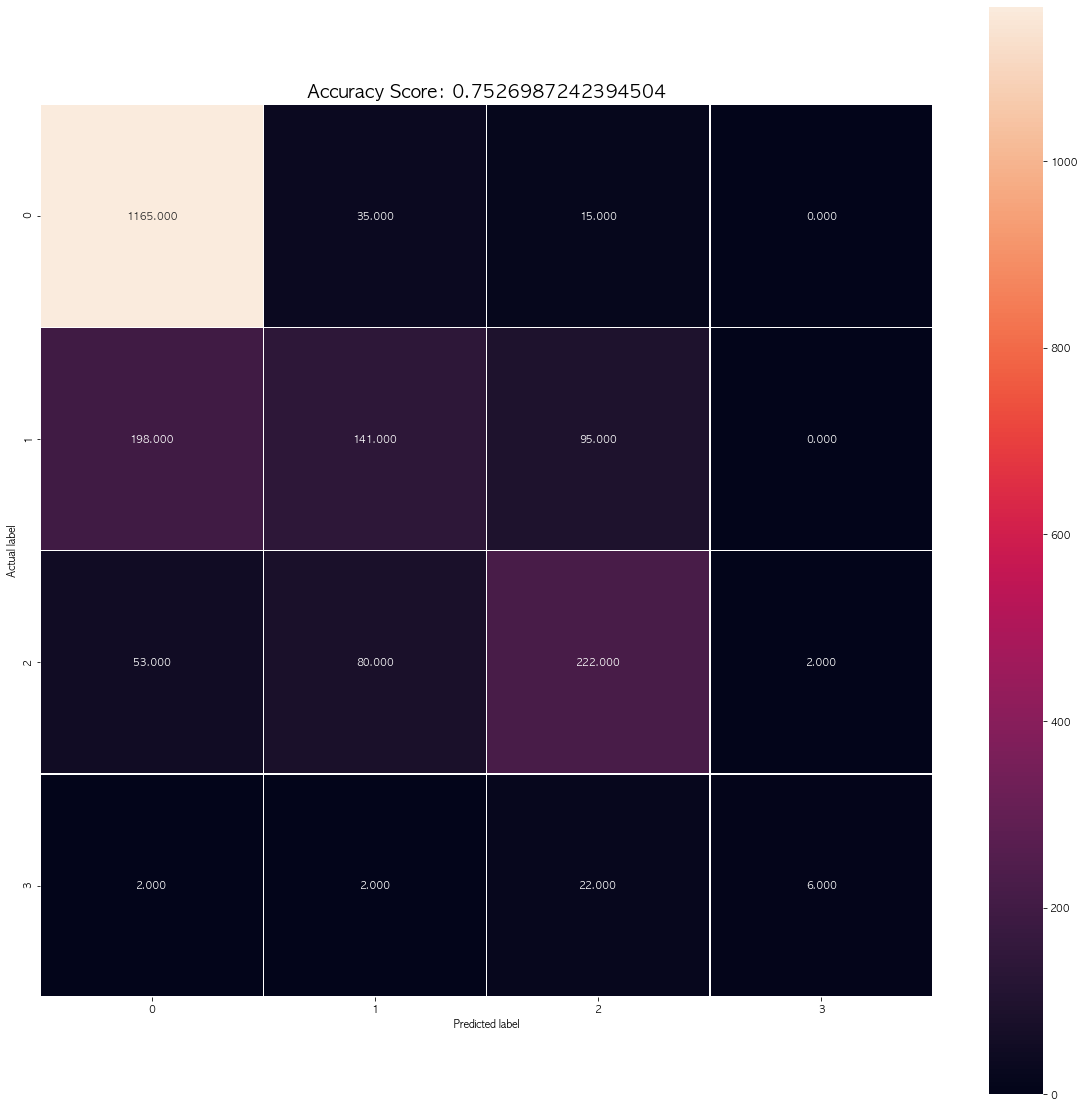

In [68]:
plt.figure(figsize=(20,20)) # chart size 
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True);# , cmap = 'Blues_r' : map »ö»ó  
plt.ylabel('Actual label'); 
plt.xlabel('Predicted label'); 
all_sample_title = 'Accuracy Score: {0}'.format(acc) 
plt.title(all_sample_title, size = 18) 
plt.show() 

## 꽤 높은 정확도를 가짐을 알 수 있음

### Auto ML

In [69]:
from pycaret.classification import *

In [70]:
feature_list = list(new_grid.drop(columns = ['행정동코드','ID','GRADE_절도','GRADE_성폭력','GRADE_폭력','유소년인구','고령인구','성폭력취약인구','건축물(30_34)',
                                            '건축물(30_)', '대규모점포','대부업현황','보안등','어린이보호','어린이집','자율방범대','파출소','신호등','절도빈도_3']).columns)
feature = new_grid[feature_list]

In [71]:
# 'voted' 컬럼이 예측 대상이므로 target 인자에 명시
# 'voted' column is the target variable
clf = setup(data = feature,
            train_size = 0.99,
            target = '절도빈도_4',
            use_gpu = False, 
            session_id = 123,
           fold_shuffle = True)

,Description,Value
0,session_id,123
1,Target,절도빈도_4
2,Target Type,Multiclass
3,Label Encoded,"0: 0, 1: 1, 2: 2, 3: 3"
4,Original Data,"(2038, 19)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [72]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7412,0.8776,0.4858,0.7073,0.7135,0.5071,0.5198,0.7290
et,Extra Trees Classifier,0.7353,0.8630,0.4709,0.7020,0.7126,0.5066,0.5138,0.3200
gbc,Gradient Boosting Classifier,0.7318,0.8717,0.4837,0.7050,0.7149,0.5063,0.5104,0.9980
rf,Random Forest Classifier,0.7288,0.8641,0.4612,0.6947,0.7064,0.4951,0.5015,0.3560
catboost,CatBoost Classifier,0.7273,0.8623,0.4633,0.6964,0.7061,0.4947,0.5010,5.0060
lda,Linear Discriminant Analysis,0.7219,0.8623,0.4948,0.6933,0.6971,0.4749,0.4862,0.0190
ridge,Ridge Classifier,0.7204,0.0000,0.4343,0.6651,0.6694,0.4489,0.4755,0.0150
lightgbm,Light Gradient Boosting Machine,0.7174,0.8477,0.4703,0.6914,0.7004,0.4810,0.4852,2.1280
qda,Quadratic Discriminant Analysis,0.7134,0.8637,0.4344,0.6841,0.6898,0.4531,0.4630,0.0300
xgboost,Extreme Gradient Boosting,0.7125,0.8475,0.4568,0.6861,0.6956,0.4729,0.4771,2.6280


In [73]:
blended = blend_models(estimator_list = best_5, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7153,0.8672,0.4561,0.6825,0.6944,0.4755,0.4804
1,0.7401,0.8622,0.4691,0.6995,0.7108,0.5112,0.5215
2,0.7270,0.8778,0.4634,0.6966,0.7075,0.4963,0.5010
3,0.7568,0.8686,0.4853,0.7201,0.7317,0.5414,0.5504
4,0.7469,0.8868,0.4645,0.7143,0.7268,0.5239,0.5297
Mean,0.7372,0.8725,0.4677,0.7026,0.7142,0.5097,0.5166
SD,0.0146,0.0088,0.0097,0.0134,0.0135,0.0226,0.0240


In [74]:
rf = create_model('rf', cross_validation=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7228,0.8973,0.4532,0.6847,0.6984,0.4814,0.4878
1,0.7079,0.8296,0.4570,0.6878,0.6963,0.4678,0.4695
2,0.7624,0.8575,0.4962,0.7298,0.7408,0.5571,0.5635
3,0.7277,0.8497,0.4529,0.6861,0.6975,0.4896,0.4993
4,0.7376,0.8720,0.4619,0.7009,0.7150,0.5067,0.5129
5,0.6832,0.8666,0.4397,0.6585,0.6683,0.4320,0.4342
6,0.7624,0.8640,0.5110,0.7240,0.7353,0.5637,0.5717
7,0.7015,0.8440,0.4168,0.6632,0.6754,0.4282,0.4369
8,0.7264,0.8700,0.4488,0.6884,0.7039,0.4890,0.4942
9,0.7562,0.8903,0.4749,0.7233,0.7336,0.5355,0.5451


In [76]:
plot_model(rf)

IntProgress(value=0, description='Processing: ', max=5)

ValueError: Found input variables with inconsistent numbers of samples: [63, 84]

<Figure size 576x396 with 0 Axes>

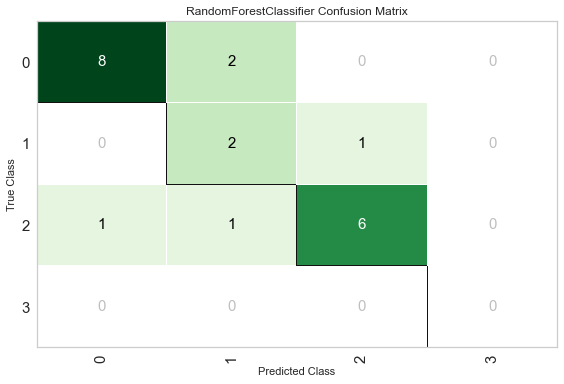

In [77]:
plot_model(rf, plot='confusion_matrix')

In [78]:
evaluate_model(rf)

,Parameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


In [79]:
plt.rc('font', family="AppleGothic")


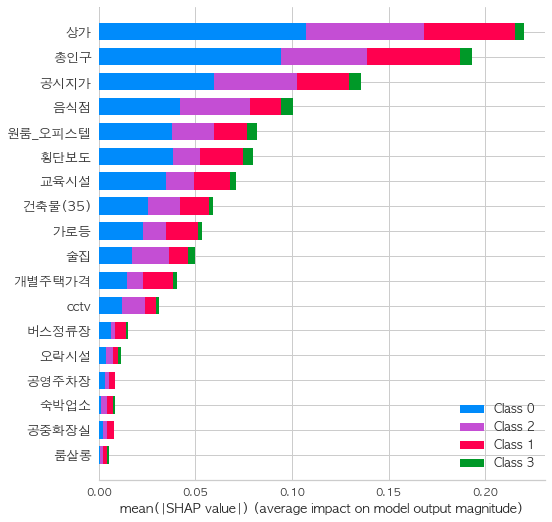

In [80]:
interpret_model(rf)

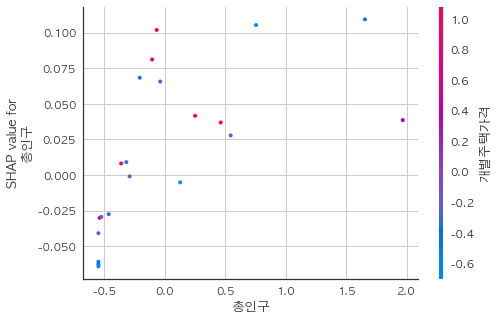

In [81]:
interpret_model(rf, plot='correlation')


In [82]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(feature.values, i) for i in range(feature.shape[1])]
vif["features"] = feature.columns 
vif

,VIF Factor,features
0,1.686550,총인구
1,1.430519,건축물(35)
2,1.162651,개별주택가격
3,2.710737,공시지가
4,1.956322,가로등
5,1.172588,공영주차장
6,1.117889,공중화장실
7,2.002425,교육시설
8,2.045773,룸살롱
9,1.385123,버스정류장
